## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
from modules.index_data import IndexData
from modules.options_data import OptionsData
from modules.strategy import Strategy
from config.expiry_map import expiry_map

plt.style.use("seaborn-v0_8-darkgrid")

## Config

In [2]:
# Config
index_data_loc = "data/NIFTY BANK.csv"
options_data_loc = "data/options/"
start_date = "2021-04"
end_date = "2021-12-30"

# Strat config
index = "BANKNIFTY"
close_time = dt.time(15, 20)
premium = 100

## Load Data & Variables

In [3]:
# Index Data
data = IndexData(
    data_loc=index_data_loc,
    start_date=start_date,
    end_date=end_date,
    expiry_map=expiry_map,
).data

# Options Data
options_obj = OptionsData(data_loc=options_data_loc, expiry_map=expiry_map)

# Strategy
strategy = Strategy(
    index_data=data,
    options_object=options_obj,
    index=index,
    nearest_premium=premium,
    close_time=close_time,
)

## Index Data Sanity Check

### Data Info

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69374 entries, 2021-04-01 09:15:00 to 2021-12-30 15:29:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ticker      69374 non-null  object        
 1   open        69374 non-null  float64       
 2   high        69374 non-null  float64       
 3   low         69374 non-null  float64       
 4   close       69374 non-null  float64       
 5   atm_strike  69374 non-null  int64         
 6   spread      69374 non-null  object        
 7   expiry      69374 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 4.8+ MB


### Close

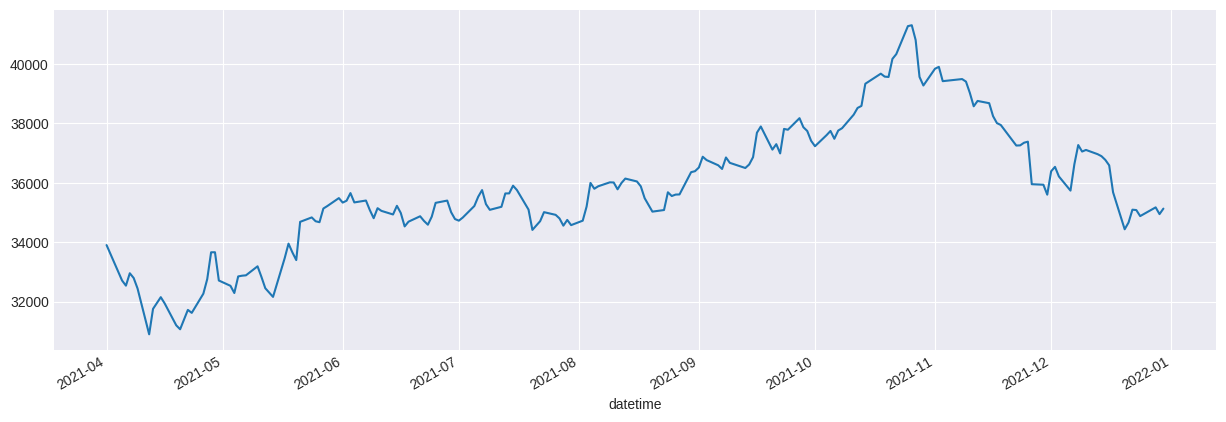

In [5]:
data.resample("D").agg(
    {"open": "first", "high": "max", "low": "min", "close": "last"}
).dropna()["close"].plot(figsize=(15, 5));

No sudden spikes or falls in the close price of the index.

### Standard Deviation

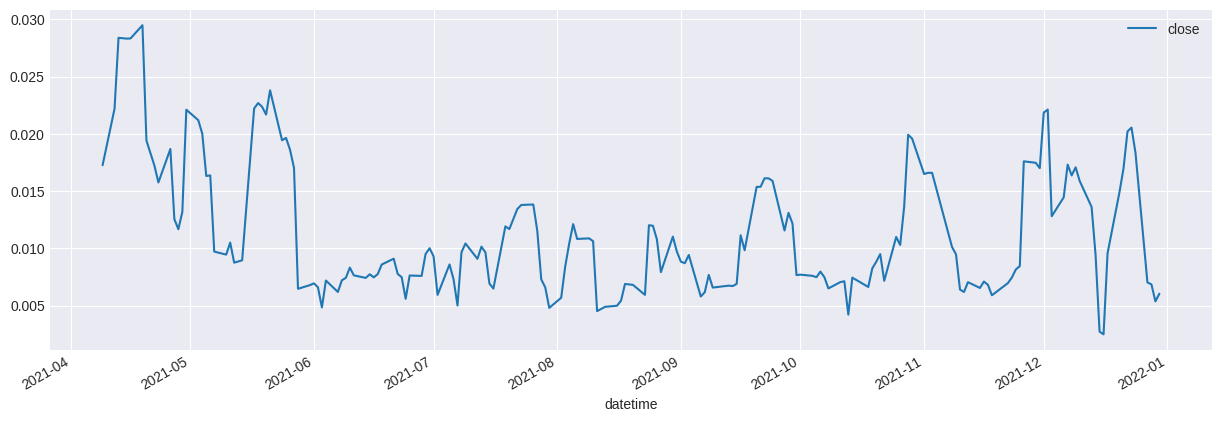

In [6]:
data.resample("D").agg(
    {"open": "first", "high": "max", "low": "min", "close": "last"}
).dropna()[["close"]].pct_change().rolling(window=5).std().plot(
    figsize=(15, 5)
);

Standard Deviation is in a well-defined range

## Strategy

### Run Strategy
The function will take time to run since it is event-based backtesting. It is recommended to load `trade_book.csv` for analysis.

### Analysis

In [7]:
trade_book = pd.read_csv("trade_book.csv", index_col=[0])
trade_book

,instrument,datetime,price,position_type,expiry
0,BANKNIFTY2140133700CE,2021-04-01 10:48:00,43.10,Entry,2021-04-01 15:30:00
1,BANKNIFTY2140133100PE,2021-04-01 13:05:00,41.55,Entry,2021-04-01 15:30:00
2,BANKNIFTY2140133700CE,2021-04-01 14:10:00,-95.65,SL,2021-04-01 15:30:00
3,BANKNIFTY2140133100PE,2021-04-01 15:20:00,-0.25,Time,2021-04-01 15:30:00
4,BANKNIFTY2140833500CE,2021-04-08 09:51:00,44.60,Entry,2021-04-08 15:30:00
...,...,...,...,...,...
127,BANKNIFTY21D2335200PE,2021-12-23 15:20:00,-2.90,Time,2021-12-23 15:30:00
128,BANKNIFTY21DEC35100CE,2021-12-30 11:00:00,51.10,Entry,2021-12-30 15:30:00
129,BANKNIFTY21DEC34900PE,2021-12-30 12:55:00,46.15,Entry,2021-12-30 15:30:00
130,BANKNIFTY21DEC35100CE,2021-12-30 13:39:00,-108.00,SL,2021-12-30 15:30:00
